Loading image: /home/administrator/Desktop/datascience/github/cascadia-vlm-challenge/public/player-regions.png
Sending to Gemini for segmentation...
Received 158 segmented objects
  Breakdown: {'tile_hex': 81, 'hawk': 20, 'salmon': 17, 'fox': 9, 'bear': 15, 'elk': 16}
Creating overlay visualization...
  [FAIL 119] bear: KeyError: 'box_2d'
  [FAIL 143] bear: KeyError: 'box_2d'
  [FAIL 145] salmon: KeyError: 'box_2d'
✓ Saved overlay to: ./segmentation_outputs/final_overlay.png
✓ Processed: 149 successful, 9 failed


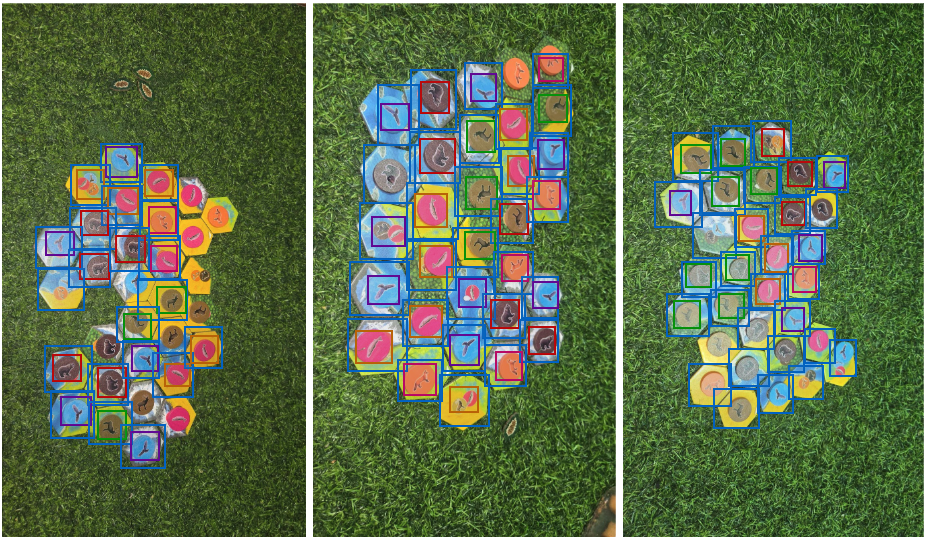

In [2]:
# SPLIT INTO 2 FUNCTIONS - Segmentation & Overlay (avoids costly LLM re-runs)
import base64
import io
from PIL import Image, ImageDraw
from google import genai
from google.genai import types
import json
import os
from collections import Counter

def segment_with_gemini(image_path: str):
    """
    Step 1: Segment image using Gemini API.
    
    Args:
        image_path: Path to input image
    
    Returns: (segmentation_objects, raw_api_response)
    """
    # Initialize client
    client = genai.Client()
    
    # Load and prepare image
    print(f"Loading image: {image_path}")
    original_image = Image.open(image_path)
    
    # Create thumbnail for API
    im = original_image.copy()
    im.thumbnail([1024, 1024], Image.Resampling.LANCZOS)
    
    # Segment with Gemini
    print("Sending to Gemini for segmentation...")
    prompt = """
    You are analyzing a Cascadia board game state for a player.
    
    I need you to identify and segment every game piece on the board:
    - Hexagonal habitat tiles (labeled as "tile_hex")
    - Wildlife tokens placed on tiles: bear, elk, salmon, hawk, fox
    
    Please identify ALL pieces individually:
    - Each hex tile should be a separate segment
    - Each animal token should be a separate segment
    - Do NOT combine multiple pieces into one
    - Ignore the background (grass/table)
    
    Return JSON with these exact labels:
    ["tile_hex", "bear", "elk", "salmon", "hawk", "fox"]

    For each detected piece, provide:
    - "label": the type of piece
    - "box_2d": [ymin, xmin, ymax, xmax] normalized to 0-1000
    - "mask": base64 PNG mask that precisely outlines the piece
    
    Return ONLY valid JSON array (no markdown formatting).
    """
    
    config = types.GenerateContentConfig(response_mime_type="application/json")
    response = client.models.generate_content(
        model="gemini-3-pro-preview",
        contents=[prompt, im],
        config=config
    )
    
    # Parse response
    objects = json.loads(response.text)
    print(f"✓ Received {len(objects)} segmented objects")
    
    # Count by label
    label_counts = Counter([obj['label'] for obj in objects])
    print(f"  Breakdown: {dict(label_counts)}")
    
    return objects, response


def create_overlay_visualization(image_path: str, segmentation_objects: list, output_path: str = None):
    """
    Step 2: Create overlay visualization from segmentation data.
    
    Args:
        image_path: Path to original image
        segmentation_objects: List of segmented objects from segment_with_gemini()
        output_path: Optional path to save overlay image
    
    Returns: overlay image (PIL Image)
    """
    # Load original image
    print(f"Loading image for overlay: {image_path}")
    original_image = Image.open(image_path)
    
    # Define colors
    label_colors = {
        'tile_hex': (100, 200, 255, 200),
        'bear': (255, 80, 80, 200),
        'elk': (80, 255, 80, 200),
        'salmon': (255, 165, 0, 200),
        'hawk': (200, 80, 255, 200),
        'fox': (255, 80, 180, 200)
    }
    
    border_colors = {
        'tile_hex': (0, 100, 200),
        'bear': (200, 0, 0),
        'elk': (0, 150, 0),
        'salmon': (200, 100, 0),
        'hawk': (100, 0, 150),
        'fox': (200, 0, 100)
    }
    
    # Create overlay in memory
    print("Creating overlay visualization...")
    original_rgba = original_image.convert('RGBA')
    overlay = Image.new('RGBA', original_rgba.size, (0, 0, 0, 0))
    draw = ImageDraw.Draw(original_rgba)
    
    success_count = 0
    fail_count = 0
    
    for i, obj in enumerate(segmentation_objects):
        try:
            label = obj['label']
            box = obj['box_2d']
            png_str = obj['mask']
            
            # Calculate bounding box
            y0 = int(box[0] / 1000 * original_image.size[1])
            x0 = int(box[1] / 1000 * original_image.size[0])
            y1 = int(box[2] / 1000 * original_image.size[1])
            x1 = int(box[3] / 1000 * original_image.size[0])
            
            if y0 >= y1 or x0 >= x1:
                fail_count += 1
                if fail_count <= 3:  # Show first 3 failures
                    print(f"  [SKIP {i}] {label}: Invalid bbox {box}")
                continue
            
            # Decode mask
            if png_str.startswith("data:image/png;base64,"):
                png_str = png_str.removeprefix("data:image/png;base64,")
            
            mask_data = base64.b64decode(png_str)
            mask_img = Image.open(io.BytesIO(mask_data))
            
            # Convert to grayscale
            if mask_img.mode != 'L':
                mask_img = mask_img.convert('L')
            
            # Resize mask to bbox
            target_width = x1 - x0
            target_height = y1 - y0
            
            try:
                mask_img = mask_img.resize((target_width, target_height), Image.Resampling.BILINEAR)
            except OSError:
                mask_img = mask_img.convert('RGB').resize((target_width, target_height), Image.Resampling.BILINEAR)
                mask_img = mask_img.convert('L')
            
            # Create colored mask
            color = label_colors.get(label, (200, 200, 200, 200))
            colored_mask = Image.new('RGBA', (target_width, target_height), color)
            colored_mask.putalpha(mask_img)
            
            # Paste onto overlay
            overlay.paste(colored_mask, (x0, y0), colored_mask)
            
            # Draw bounding box
            border_color = border_colors.get(label, (100, 100, 100))
            draw.rectangle([x0, y0, x1, y1], outline=border_color, width=2)
            
            success_count += 1
            
        except Exception as e:
            fail_count += 1
            if fail_count <= 3:  # Show first 3 failures
                print(f"  [FAIL {i}] {label}: {type(e).__name__}: {str(e)[:50]}")
    
    # Composite
    result = Image.alpha_composite(original_rgba, overlay)
    result_rgb = result.convert('RGB')
    
    # Save if output path provided
    if output_path:
        # Create output directory if it doesn't exist
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        result_rgb.save(output_path)
        print(f"✓ Saved overlay to: {output_path}")
    
    print(f"✓ Processed: {success_count} successful, {fail_count} failed")
    
    return result_rgb


# ============ USAGE EXAMPLES ============

# Step 1: Segment with Gemini (expensive LLM call - do once!)
segmentation_data, api_response = segment_with_gemini(
    image_path="/home/administrator/Desktop/datascience/github/cascadia-vlm-challenge/public/player-regions.png"
)

# Step 2: Create overlay (can re-run many times without LLM cost)
result_image = create_overlay_visualization(
    image_path="/home/administrator/Desktop/datascience/github/cascadia-vlm-challenge/public/player-regions.png",
    segmentation_objects=segmentation_data,
    output_path="./segmentation_outputs/final_overlay.png"
)

# Display result
result_image

In [3]:
player_regions = Image.open("./public/player-regions.png")
scoring_rules = Image.open("./public/scoring-rules.jpg")
score_table = Image.open("./public/score-table.jpg")
ss_regions = Image.open("./segmentation_outputs/final_overlay.png")

In [6]:
client = genai.Client()

response = client.models.generate_content(
    model="gemini-3-pro-preview",
    contents=[
        player_regions,
        scoring_rules,
        score_table,
        ss_regions,
        """
            You are a board-game scoring assistant for Cascadia.

            You are given MULTIPLE inputs:
            1) Player region board image (tiles on grass background) - PRIMARY SOURCE
            2) Scoring rules image
            3) Empty scoring table image
            4) Segmentation overlay image (AI-annotated regions for reference)

            CRITICAL: The segmentation overlay (image 4) is AI-generated and may contain errors.
            Do NOT blindly trust it. Use it as a HELPER, not ground truth.

            TASK:
            Fill the scoring table STRICTLY based on visual analysis of the actual game board.

            PROCESS (internal, do NOT output):
            1. Examine the player region image (image 1) directly to identify tiles and tokens
            2. Use the segmentation overlay as a reference guide to locate pieces
            3. CROSS-CHECK: If the overlay suggests something, verify it in the original image
            4. Count tiles by habitat type (forest, wetland, prairie, mountain, river)
            5. Count wildlife tokens by species (bear, elk, salmon, hawk, fox)
            6. Analyze groupings and corridors as per scoring rules
            7. If segmentation conflicts with what you see in the original image, trust the original
            8. Do NOT count pieces that only appear in the overlay but not in the original image
            9. Do NOT infer or guess missing pieces

            OUTPUT RULES:
            - Output ONLY the completed scoring table
            - Use Markdown table format
            - Use integers only
            - Preserve the exact table structure (rows, columns, labels)
            - Replace image icons with text labels (e.g., "Bear", "Elk", "Salmon", "Hawk", "Fox")
            - If any value cannot be determined visually from the ORIGINAL image, write "UNDETERMINED"
            - Do NOT explain reasoning
            - Do NOT guess
            """
    ],
    # config=types.GenerateContentConfig(
    #     temperature=0.1,
    #     top_p=0.95,
    #     thinking_config=types.ThinkingConfig(
    #         thinking_level="medium"
    #     )
    # )
)
with open("response.md", "w", encoding="utf-8") as f:
    f.write(response.text)

In [7]:
from IPython.display import Markdown, display
display(Markdown(response.text))

Based on the visual analysis of the board state (Image 1), the scoring rules (Image 2), and the structure of the Cascadia scoring pad (Image 3), here is the completed scoring table for the three player regions shown (Left, Middle, Right).

**Assumptions:**
*   **Player 1** is the **Left** board.
*   **Player 2** is the **Middle** board.
*   **Player 3** is the **Right** board.
*   **Scoring Cards:**
    *   **Bear (B):** Groups of exactly 3 (10 pts).
    *   **Elk (B):** Shape-based groups (1=2, 2=5, 3=9, 4=13).
    *   **Salmon (C):** Runs of 3 (10), 4 (12), 5+ (15).
    *   **Hawk (B):** Number of connected hawks (2=2, 3=5, 4=9, etc.).
    *   **Fox (C):** Unique adjacent animal types (1=1, 2=2, 3=3, etc.).
*   **Habitat Bonuses:** 3 points for the largest area of a type, 1 point for the second largest. Ties for 1st split points (2 each); ties for 2nd get 0.

### Cascadia Scoring Table

| Category | Player 1 (Left) | Player 2 (Middle) | Player 3 (Right) |
| :--- | :---: | :---: | :---: |
| **Bear** | 0 | 0 | 0 |
| **Elk** | 20 | 18 | 7 |
| **Salmon** | 0 | 10 | 0 |
| **Hawk** | 2 | 5 | 2 |
| **Fox** | 5 | 11 | 6 |
| **WILDLIFE TOTAL** | **27** | **44** | **15** |
| | | | |
| **Mountain** (Size + Bonus) | 1 + 0 | 1 + 0 | 3 + 3 |
| **Forest** (Size + Bonus) | 2 + 0 | 4 + 3 | 2 + 0 |
| **Prairie** (Size + Bonus) | 7 + 3 | 5 + 1 | 3 + 0 |
| **Wetland** (Size + Bonus) | 2 + 3 | 1 + 1 | 0 + 0 |
| **River** (Size + Bonus) | 3 + 0 | 5 + 3 | 3 + 0 |
| **HABITAT TOTAL** | **21** | **24** | **14** |
| | | | |
| **Nature Tokens** | 1 | 1 | 1 |
| **GRAND TOTAL** | **49** | **69** | **30** |